# Generative modelling in deep learning
## Gauthier MULTARI

*This notebook consists of common introductory questions, followed by 4 different generative models, and a common conclusive question. **Choose & implement 2 among the 4 models**, not all of them! If you train more models, write down below the 2 ones you want to be graded on. Do not forget the last common question.*

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

> 1. **Kullback-Leibler Divergence**:
>   $$D_{KL}(p_D || p_\theta) = \sum_x p_D(x) \log \frac{p_D(x)}{p_\theta(x)}$$

> 2. **Wasserstein Distance**:
>   $$W(p_D, p_\theta) = \inf_{\gamma \in \Gamma(p_D, p_\theta)} \mathbb{E}_{(x, y) \sim \gamma} [||x - y||]$$
>
>   where $\Gamma(p_D, p_\theta)$ is the set of all joint distributions whose marginals are $p_D$ and $p_\theta$ respectively.


Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> - When using density-based comparison methods, it's important to ensure accurate estimation of the density, as inaccuracies can lead to biased results. These methods often assume specific distribution forms, which may not hold true in all cases, and they can be sensitive to outliers. 

> - Sample-based methods, on the other hand, face challenges with sample quality and computational complexity. Generating biased samples or samples that don't adequately represent the distribution can affect the reliability of comparisons. 

In this work, we will focus on the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GAN), Variational AutoEncoders (VAE), Normalizing Flows and Diffusion Models, in order to compare them and understand their strengths and weaknesses.

### Dataset

#### Checkerboard (prioritize this dataset)

In [2]:
import torch
import math
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

def generate_batch(num_datapoints: int) -> np.ndarray:
  """Checkerboard dataset."""
  x1 = np.random.rand(num_datapoints) * 4 - 2
  x2 = np.random.rand(num_datapoints) - np.random.randint(0, 2, [num_datapoints]) * 2. + np.floor(x1) % 2
  data = np.stack([x1, x2]).T * 2
  data = (data - data.mean(axis=0)) / data.std(axis=0) 
  return torch.from_numpy(data.astype(np.float32))

train_data = generate_batch(5000)

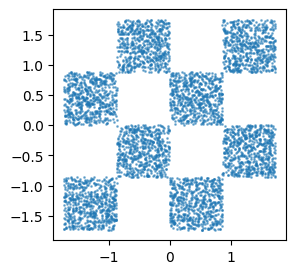

In [3]:
plt.figure(figsize=(3, 3))
plt.scatter(train_data.numpy()[:,0], train_data.numpy()[:,1], s=1.0, alpha=0.5)
plt.show()

It's also good to visualize the density as sometimes generative models overfit particular region of space. Once models are trained, when you sample from them, plot the two densities side-by-side to compare real & synthetic dataset.

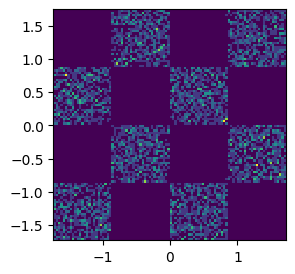

In [4]:
plt.figure(figsize=(3, 3))
plt.hist2d(train_data.numpy()[:,0], train_data.numpy()[:,1], bins=100)
plt.show()

#### Moon (use this one only if your models struggle on checkerboard)

In [5]:
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

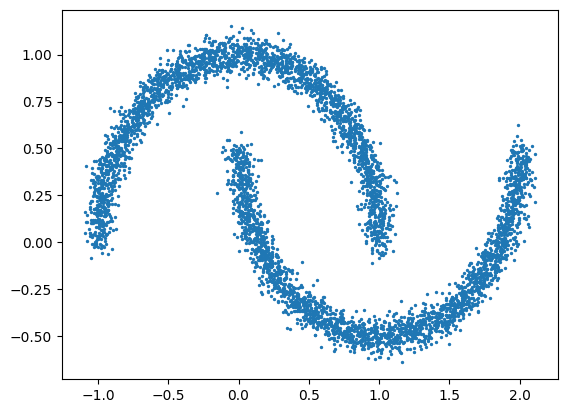

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

It's also good to visualize the density as sometimes generative models overfit particular areas. Once models are trained, when you sample from them, plot the two densities side-by-side to compare real & synthetic dataset.

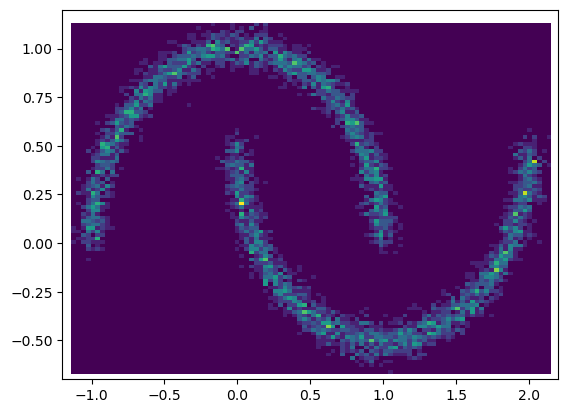

In [6]:
plt.hist2d(batch.numpy()[:,0], batch.numpy()[:,1], bins=100)
plt.xlim([-1.2,2.2])
plt.ylim([-0.7,1.2])
plt.show()

----
### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> The choice of dimension $N$ for the input noise $\epsilon$ in a GAN has several impacts. Using higher dimensions can help the neural network capture more complex patterns in the data, thus increasing its expressivity. Additionally, higher dimensions may improve the model's robustness to variability. But it also increases computational demands and the risk of overfitting. . Therefore, the choice of N should balance these factors based on the dataset.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> If $p_\theta$ and  $p_D$  are totally different i.e. there is no overlapping between the two densities, the derivative of the JSD loss will be zero, resulting in vanishing gradient:  in this extreme case $p_\theta$ will not be able to update at all. Indeed, while $p_\theta$ and  $p_D$  are totally different then $JSD(p_\theta \| p_D)$ is constant equal to $\log 2$. In practice this can in particular lead to instabilities during training: if the discrimnator is far better than the generator, the gradient of the loss will rapidly vanish to zero and the generator won't update anymore.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

> The risk here is mode collapse. Indeed, because the loss (i.e. the discriminator) only gives feedback to the generator on samples it generated, there is no incentive for the generator to learn all the modes of the true distribution as learnin a single mode allows the generator to already get good feedback  from the discriminator.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 2)
        
    def __call__(self, z):
        return self.fc1(z)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)
    
    def __call__(self, x):
        return self.fc1(x)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.331e+00, generator: 7.003e-01


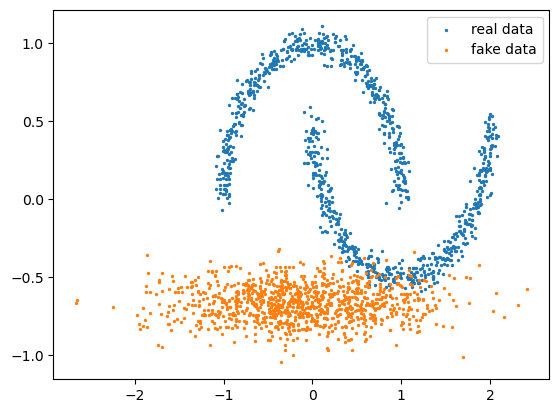

step 1000: discriminator: 1.349e+00, generator: 7.325e-01


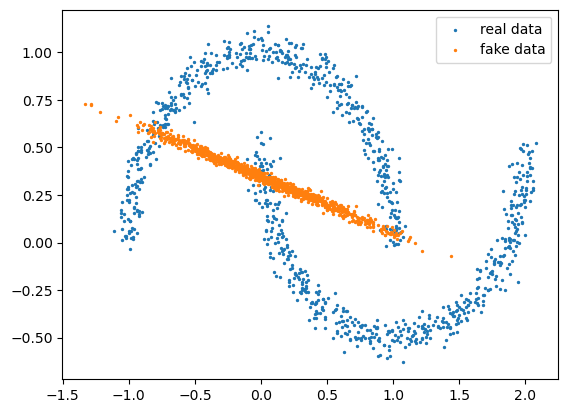

step 2000: discriminator: 1.464e+00, generator: 6.826e-01


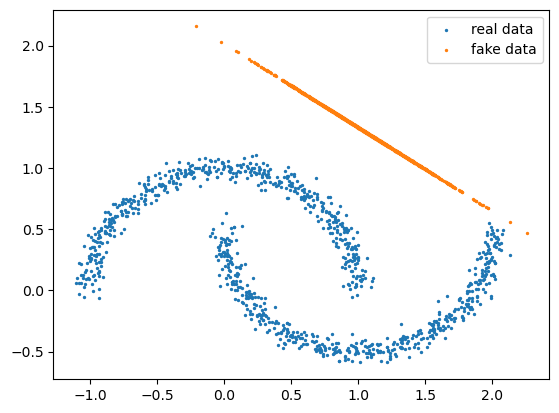

step 3000: discriminator: 1.298e+00, generator: 7.493e-01


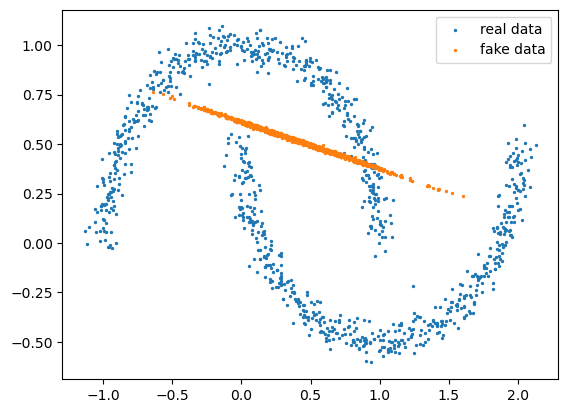

step 4000: discriminator: 1.426e+00, generator: 6.742e-01


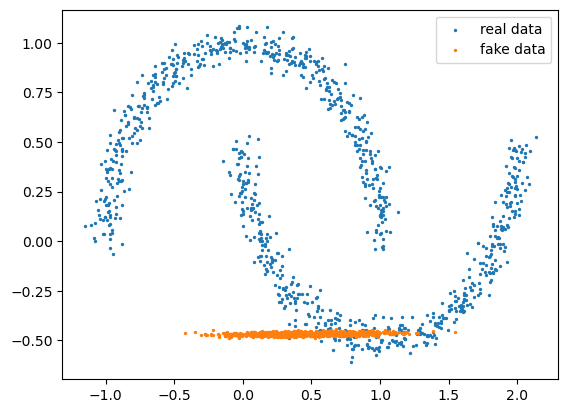

step 5000: discriminator: 1.418e+00, generator: 6.814e-01


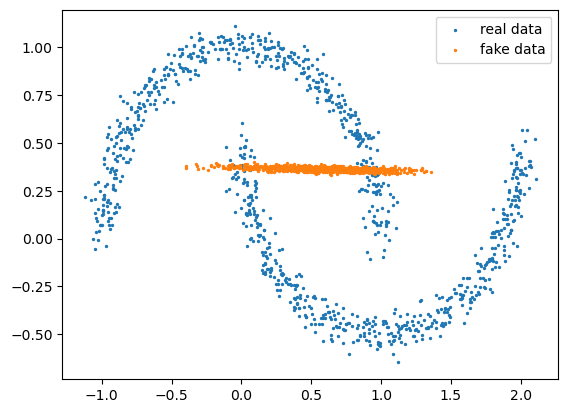

step 6000: discriminator: 1.398e+00, generator: 6.892e-01


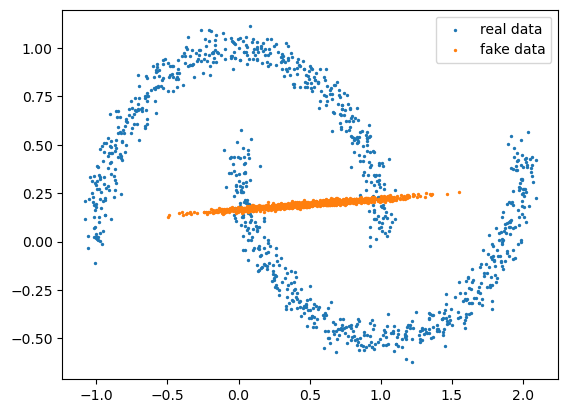

step 7000: discriminator: 1.388e+00, generator: 6.924e-01


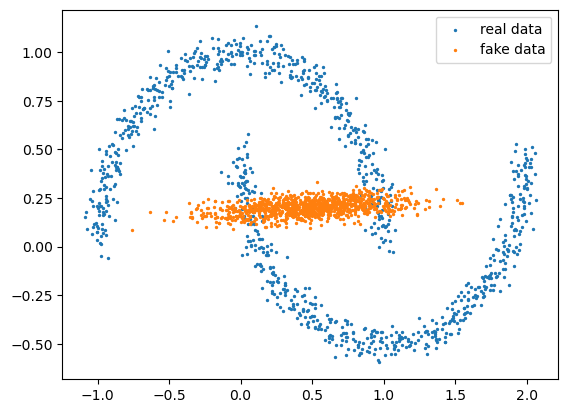

step 8000: discriminator: 1.386e+00, generator: 6.929e-01


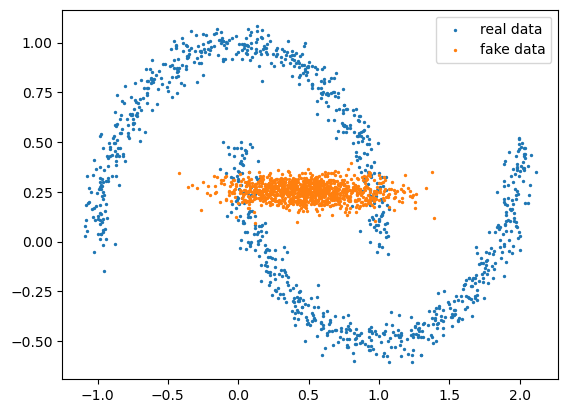

step 9000: discriminator: 1.386e+00, generator: 6.928e-01


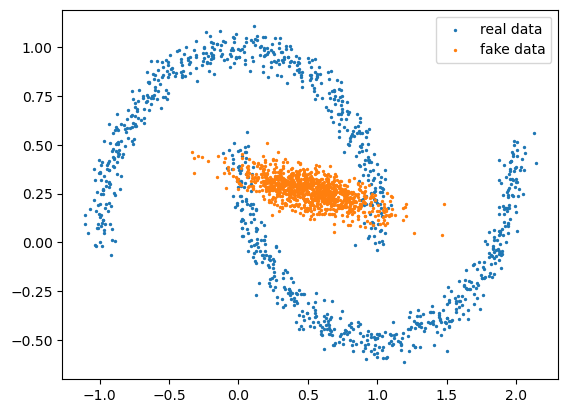

step 10000: discriminator: 1.386e+00, generator: 6.931e-01


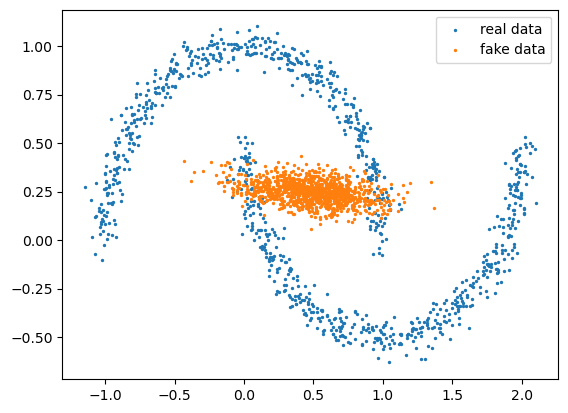

step 11000: discriminator: 1.386e+00, generator: 6.933e-01


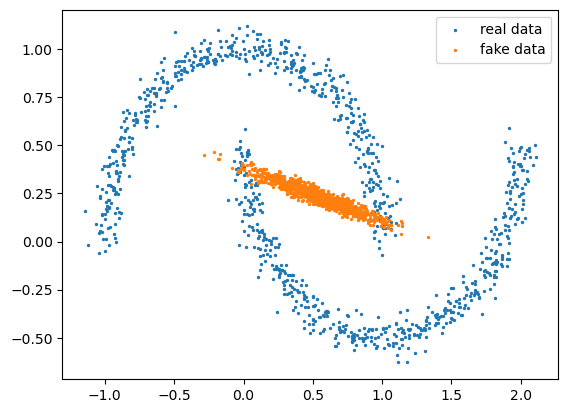

step 12000: discriminator: 1.386e+00, generator: 6.931e-01


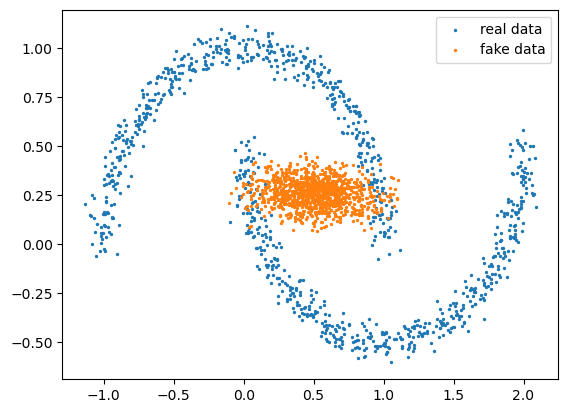

step 13000: discriminator: 1.386e+00, generator: 6.931e-01


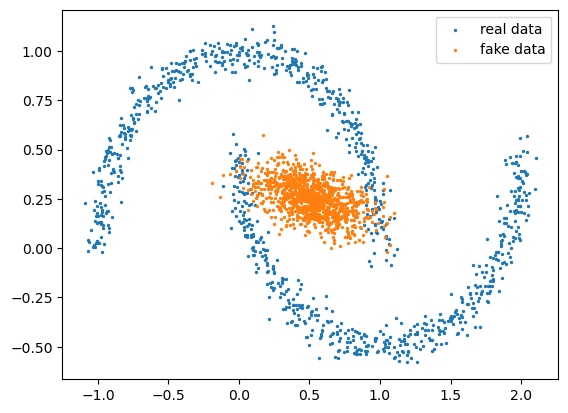

step 14000: discriminator: 1.386e+00, generator: 6.932e-01


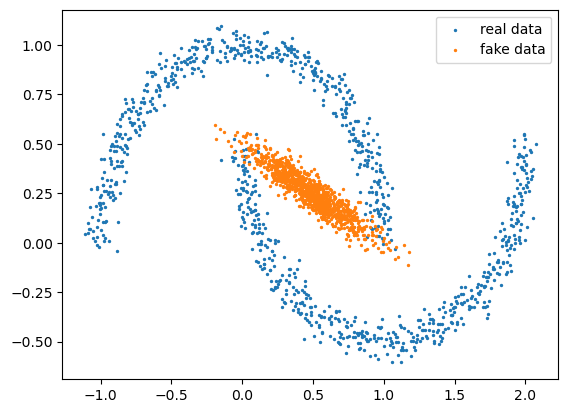

step 15000: discriminator: 1.386e+00, generator: 6.932e-01


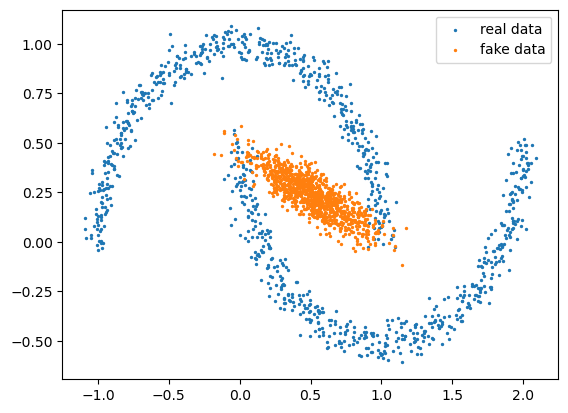

step 16000: discriminator: 1.386e+00, generator: 6.930e-01


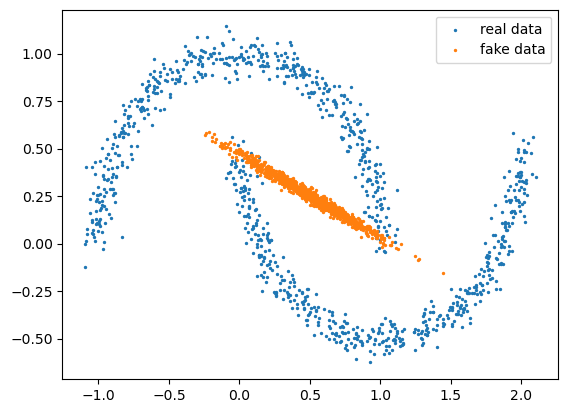

step 17000: discriminator: 1.386e+00, generator: 6.933e-01


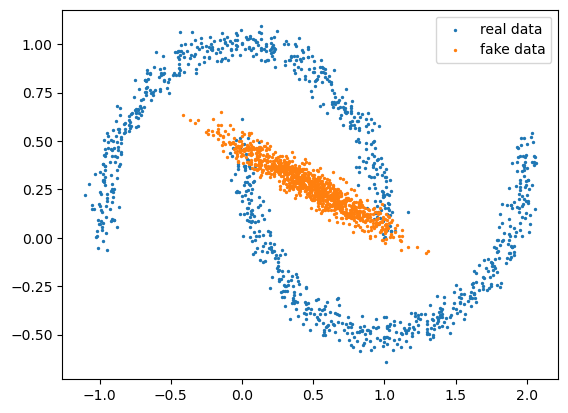

step 18000: discriminator: 1.386e+00, generator: 6.934e-01


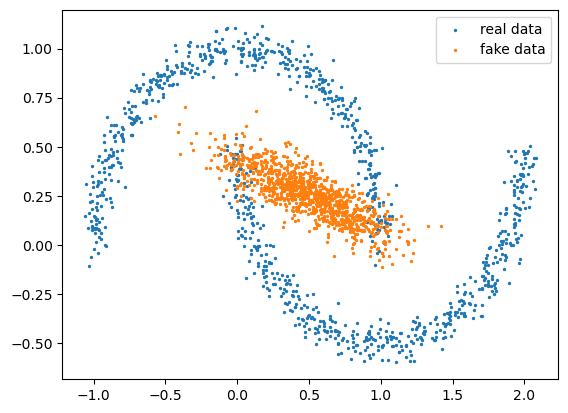

step 19000: discriminator: 1.386e+00, generator: 6.932e-01


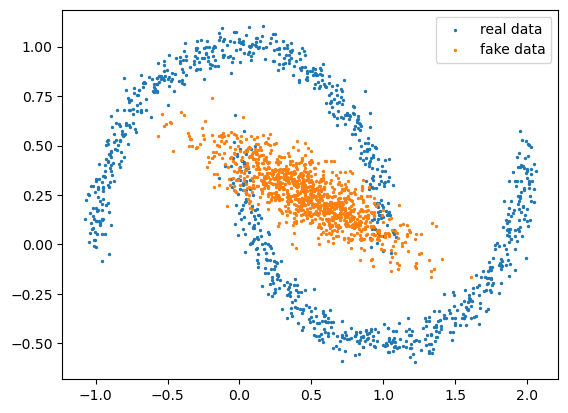

step 20000: discriminator: 1.386e+00, generator: 6.929e-01


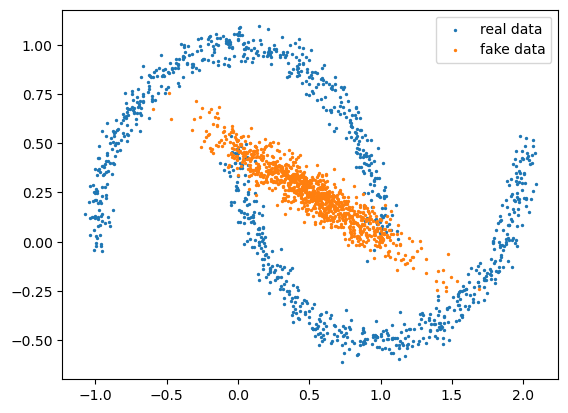

In [10]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))
criterion = F.binary_cross_entropy_with_logits

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        #
        disc_loss = criterion(discriminator(real_batch), torch.ones(BATCHLEN, 1)) + criterion(discriminator(fake_batch), torch.zeros(BATCHLEN, 1))
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    #
    gen_loss = criterion(discriminator(fake_batch), torch.ones(BATCHLEN, 1))
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> We can anticipate that the generator's loss, $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$, could lead the generator to collapse early in training because of gradient vanishing (see Q4). When the discriminator is trained very well, meaning it can accurately distinguish between real and fake samples, $D(x)$ approaches 1 for real samples and 0 for fake samples. In this scenario, the term $\log(1-D(x))$ tends to $-\infty$ for fake samples, which results in vanishing gradients during backpropagation. Consequently, the generator receives weak or no feedback to improve its performance, causing it to produce poor-quality samples or collapse entirely.


This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

In [29]:
# Define the generator
class Generator2(nn.Module):
    def __init__(self, width=8, depth=2):
        super().__init__()
        self.width = width
        self.depth = depth
        self.fc1 = nn.Linear(PRIOR_N, self.width)
        self.layers =nn.ModuleList()
        for i in range(self.depth):
          self.layers.append(nn.Linear(self.width,self.width))
          self.layers.append(nn.ReLU())
        self.fc2 = nn.Linear(self.width, 2)
        
    def __call__(self, z):
        z = self.fc1(z)
        z = F.relu(z)
        for l in self.layers:
          z = l(z)
        return self.fc2(z)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator2(nn.Module):
    def __init__(self, width=8, depth=2):
        super().__init__()
        self.width = width
        self.depth = depth
        self.fc1 = nn.Linear(2, self.width)
        self.layers =nn.ModuleList()
        for i in range(self.depth):
          self.layers.append(nn.Linear(self.width,self.width))
          self.layers.append(nn.ReLU())
        self.fc2 = nn.Linear(self.width, 1)
    
    def __call__(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        for l in self.layers:
          x = l(x)
        return self.fc2(x)

In [30]:
N_ITER = 20001
BATCHLEN = 128

def train(train_ratio, depth, width):
    generator = Generator2(width, depth)
    optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
    discriminator = Discriminator2(width, depth)
    optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))
    criterion = F.binary_cross_entropy_with_logits

    for i in range(N_ITER):
        # train the discriminator
        for _ in range(train_ratio):
            discriminator.zero_grad()
            real_batch = generate_batch(BATCHLEN)
            fake_batch = generator.generate(BATCHLEN)
            #
            # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
            #
            disc_loss = criterion(discriminator(real_batch), torch.ones(BATCHLEN, 1)) + criterion(discriminator(fake_batch), torch.zeros(BATCHLEN, 1))
            disc_loss.backward()
            optim_disc.step()
        # train the generator
        generator.zero_grad()
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE GENERATOR LOSS HERE
        #
        gen_loss = criterion(discriminator(fake_batch), torch.ones(BATCHLEN, 1))
        gen_loss.backward()
        optim_gen.step()
        if i%10000 == 0:
            print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
            # plot the result
            real_batch = generate_batch(1024)
            fake_batch = generator.generate(1024).detach()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.legend()
            plt.show()

train_ratio 1, depth 2, width 10
step 0: discriminator: 1.399e+00, generator: 6.191e-01


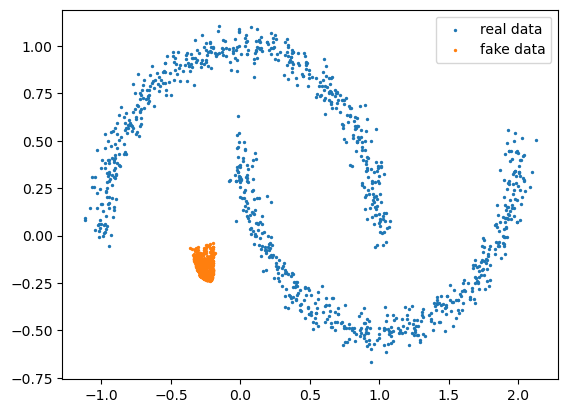

step 10000: discriminator: 1.529e+00, generator: 7.339e-01


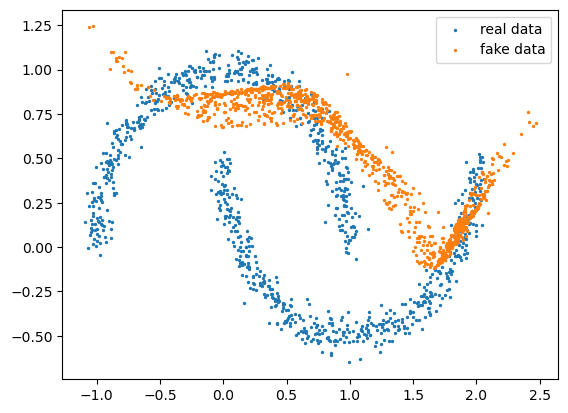

step 20000: discriminator: 1.383e+00, generator: 7.318e-01


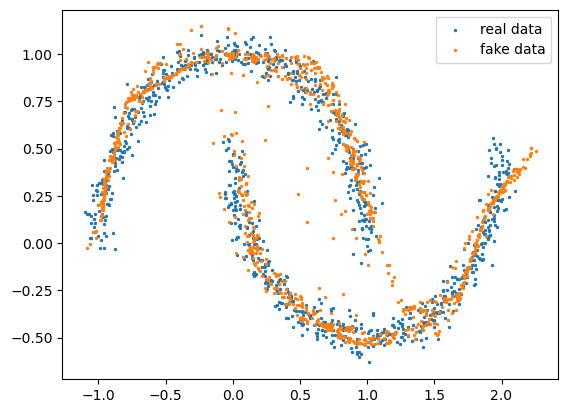

train_ratio 1, depth 2, width 50
step 0: discriminator: 1.389e+00, generator: 7.389e-01


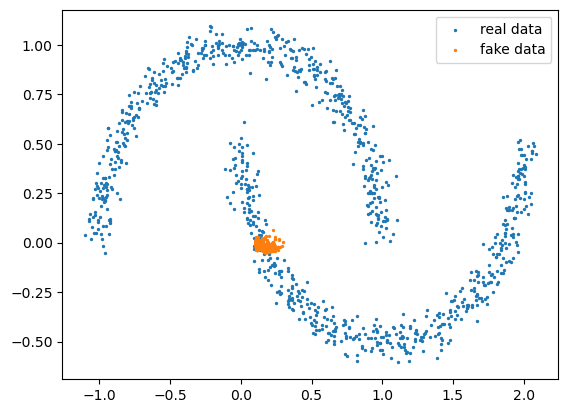

step 10000: discriminator: 1.384e+00, generator: 7.001e-01


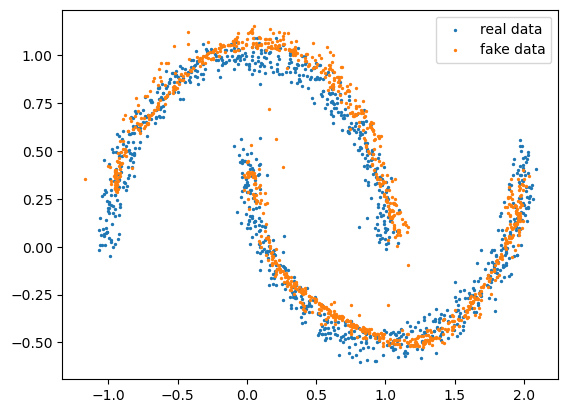

step 20000: discriminator: 1.385e+00, generator: 7.210e-01


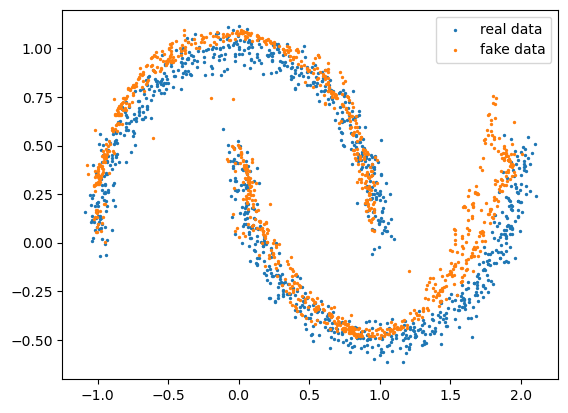

train_ratio 1, depth 2, width 150
step 0: discriminator: 1.386e+00, generator: 7.123e-01


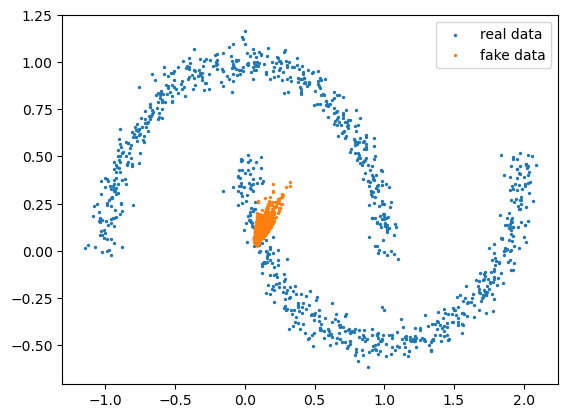

step 10000: discriminator: 1.374e+00, generator: 7.332e-01


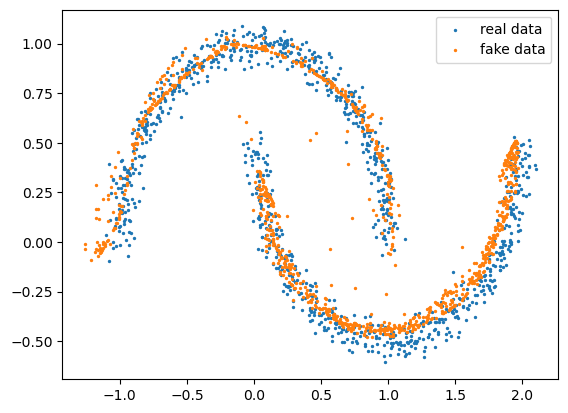

step 20000: discriminator: 1.381e+00, generator: 7.194e-01


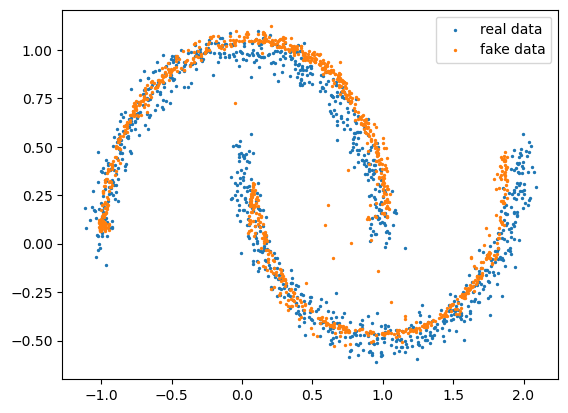

train_ratio 1, depth 5, width 10
step 0: discriminator: 1.399e+00, generator: 8.131e-01


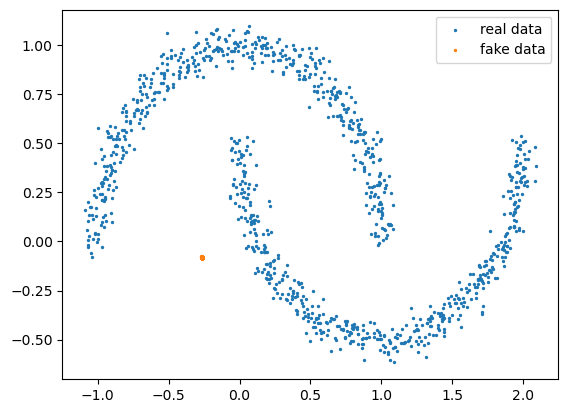

step 10000: discriminator: 1.228e+00, generator: 8.548e-01


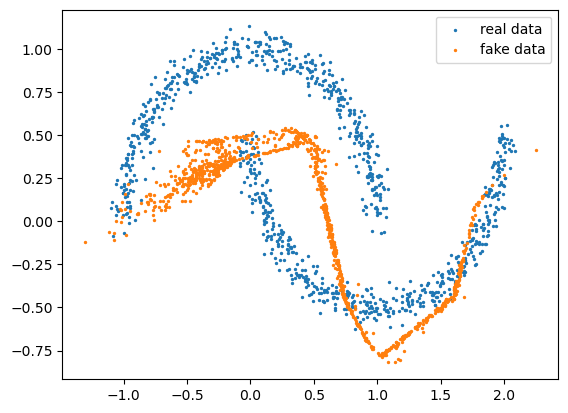

step 20000: discriminator: 1.376e+00, generator: 6.938e-01


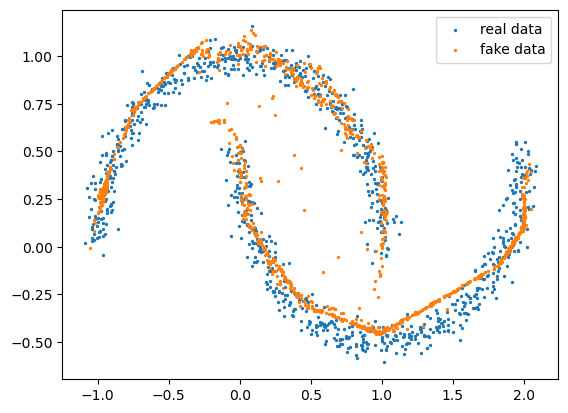

train_ratio 1, depth 5, width 50
step 0: discriminator: 1.386e+00, generator: 7.235e-01


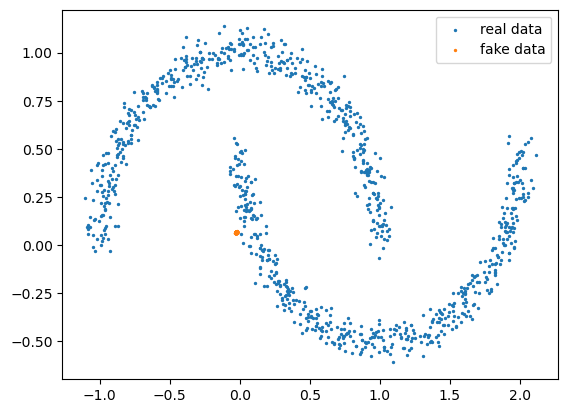

step 10000: discriminator: 1.387e+00, generator: 6.883e-01


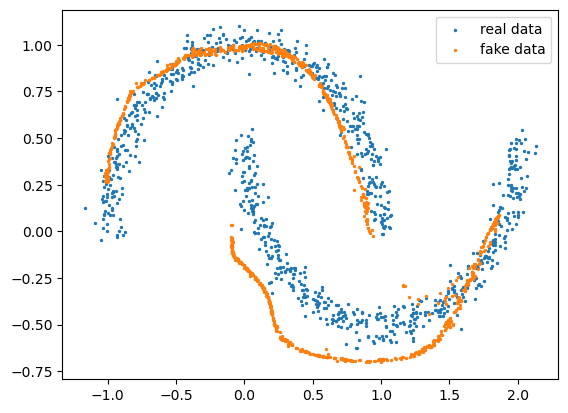

step 20000: discriminator: 1.326e+00, generator: 7.270e-01


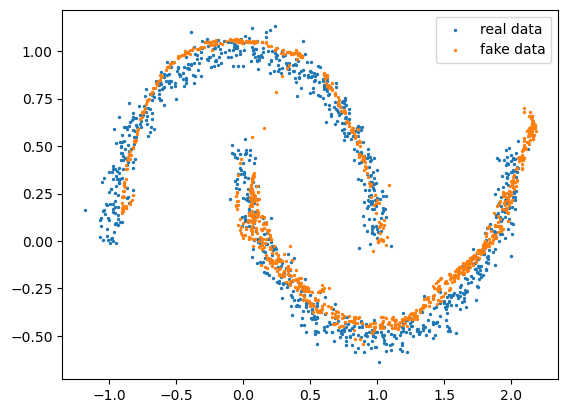

train_ratio 1, depth 5, width 150
step 0: discriminator: 1.387e+00, generator: 6.893e-01


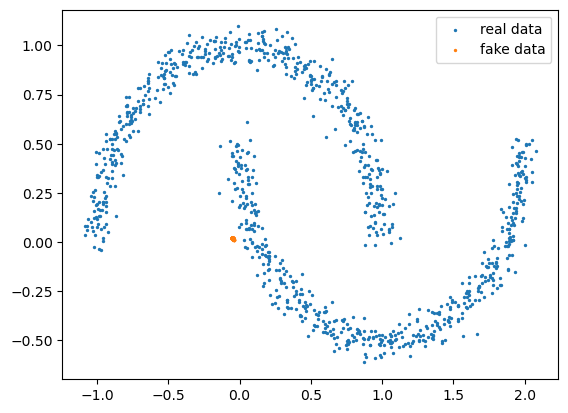

step 10000: discriminator: 1.307e+00, generator: 7.664e-01


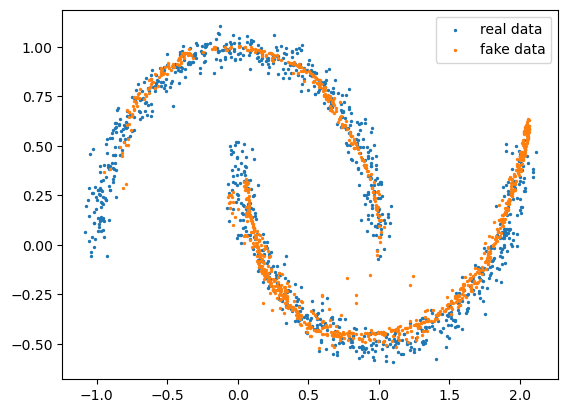

step 20000: discriminator: 1.341e+00, generator: 7.457e-01


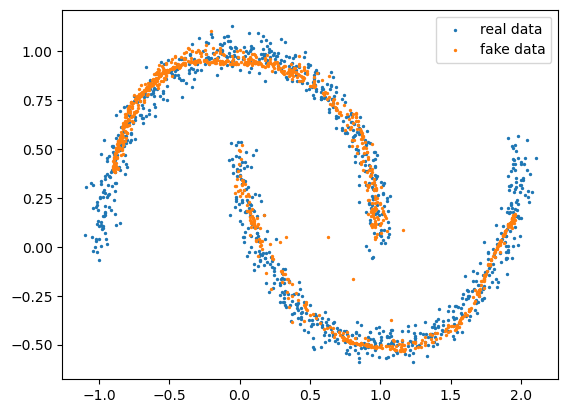

train_ratio 1, depth 10, width 10
step 0: discriminator: 1.386e+00, generator: 6.889e-01


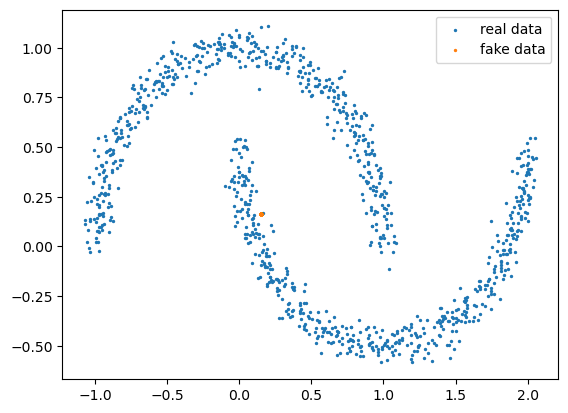

step 10000: discriminator: 1.638e+00, generator: 5.901e-01


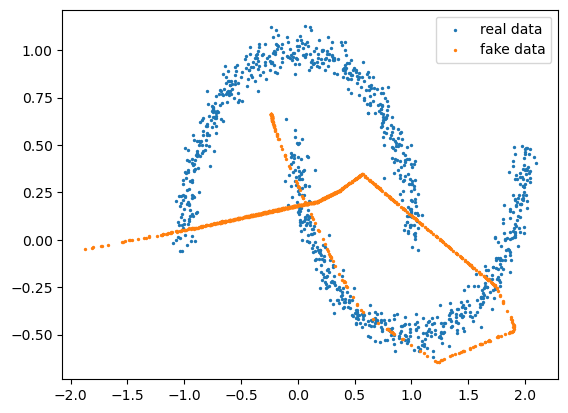

step 20000: discriminator: 1.394e+00, generator: 6.915e-01


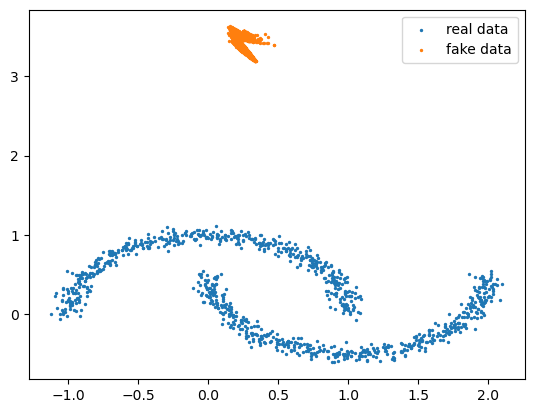

train_ratio 1, depth 10, width 50
step 0: discriminator: 1.387e+00, generator: 6.747e-01


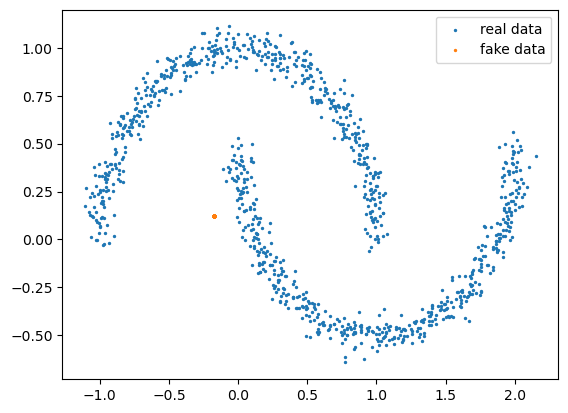

step 10000: discriminator: 1.492e+00, generator: 8.778e-01


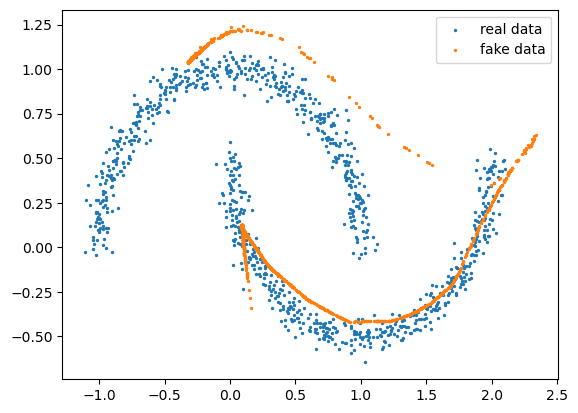

step 20000: discriminator: 1.386e+00, generator: 6.931e-01


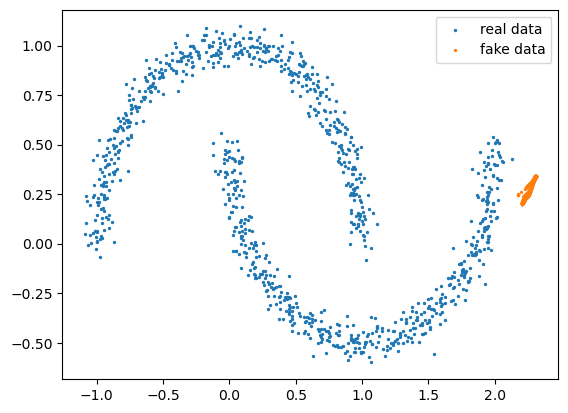

train_ratio 1, depth 10, width 150
step 0: discriminator: 1.387e+00, generator: 6.737e-01


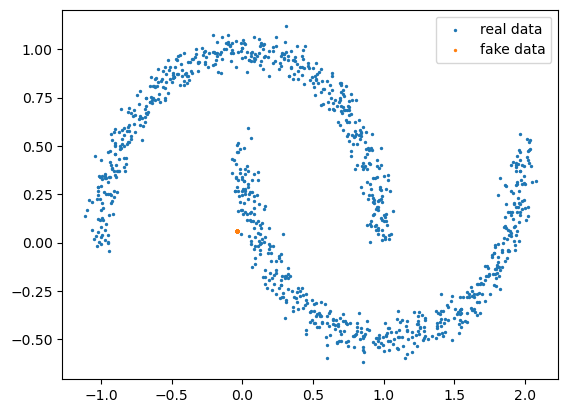

step 10000: discriminator: 1.324e+00, generator: 7.329e-01


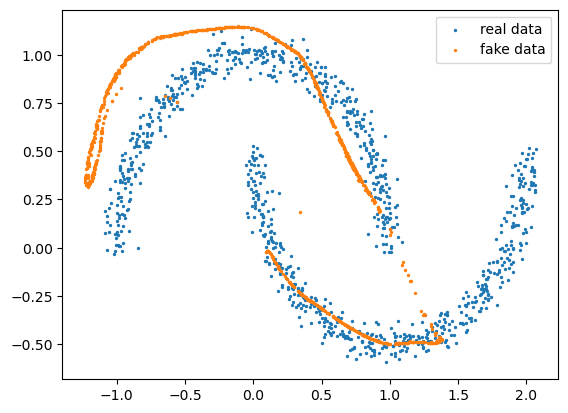

step 20000: discriminator: 1.386e+00, generator: 6.931e-01


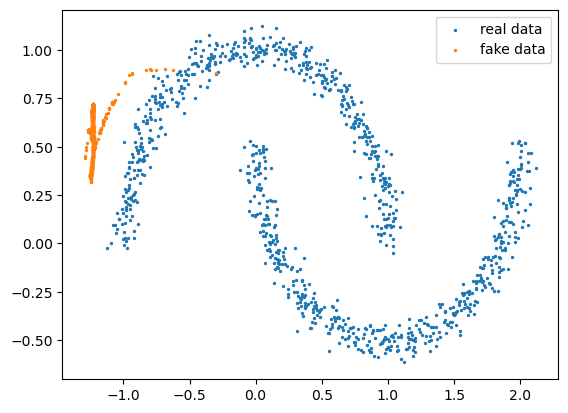

train_ratio 2, depth 2, width 10
step 0: discriminator: 1.420e+00, generator: 8.959e-01


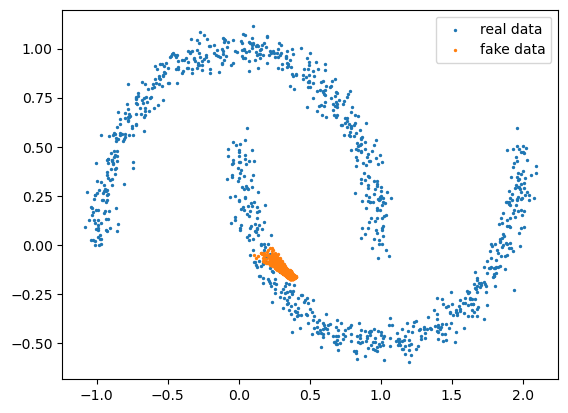

KeyboardInterrupt: 

In [31]:
for train_ratio in [1,2,5]:
    for depth in [2,5,10]:
        for width in [10,50,150]:
            print(f'train_ratio {train_ratio}, depth {depth}, width {width}')
            train(train_ratio, depth, width)

train_ratio 2, depth 5, width 50
step 0: discriminator: 1.388e+00, generator: 7.460e-01


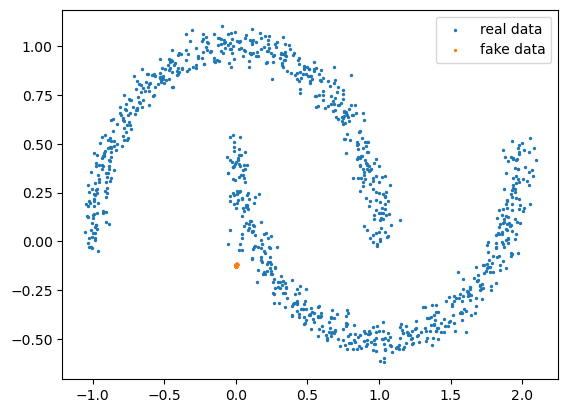

step 10000: discriminator: 1.386e+00, generator: 6.760e-01


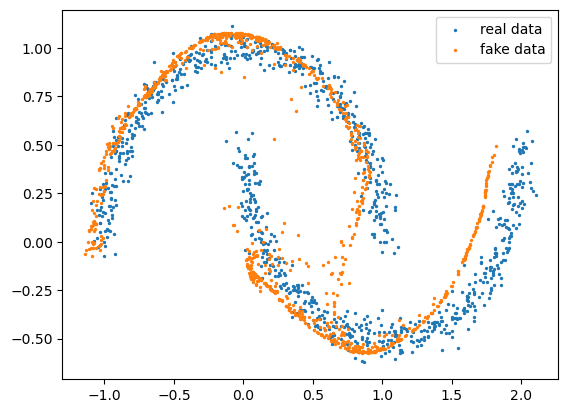

step 20000: discriminator: 1.386e+00, generator: 6.930e-01


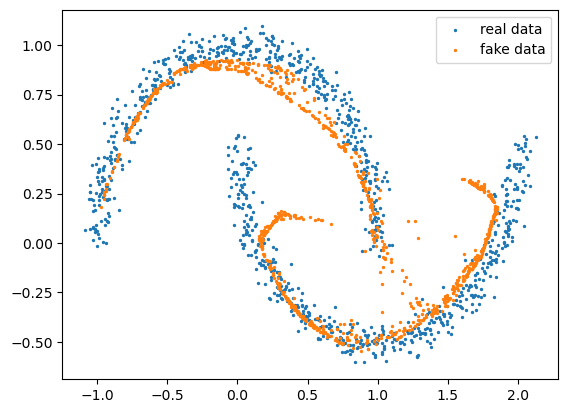

train_ratio 2, depth 5, width 100
step 0: discriminator: 1.386e+00, generator: 7.398e-01


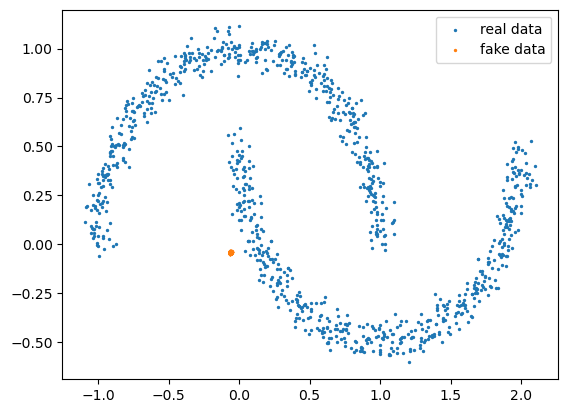

step 10000: discriminator: 1.353e+00, generator: 7.252e-01


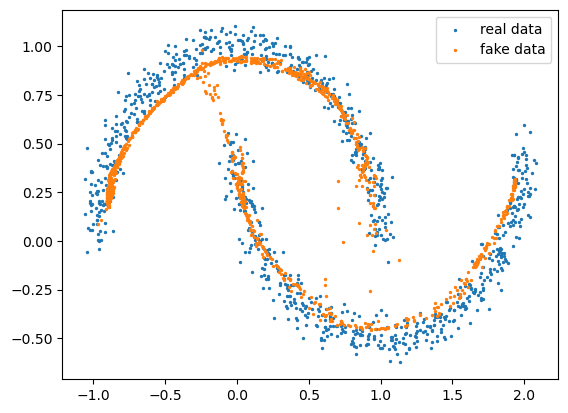

step 20000: discriminator: 1.386e+00, generator: 6.931e-01


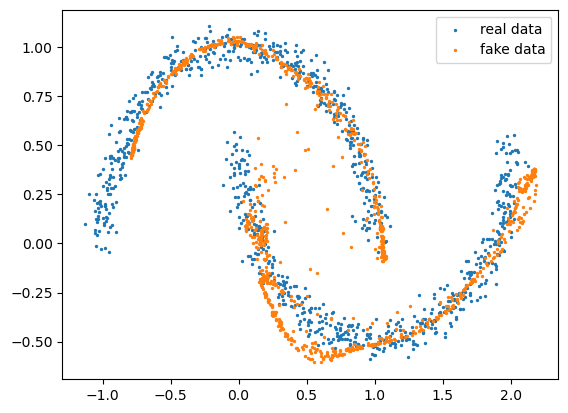

train_ratio 5, depth 5, width 50
step 0: discriminator: 1.384e+00, generator: 6.715e-01


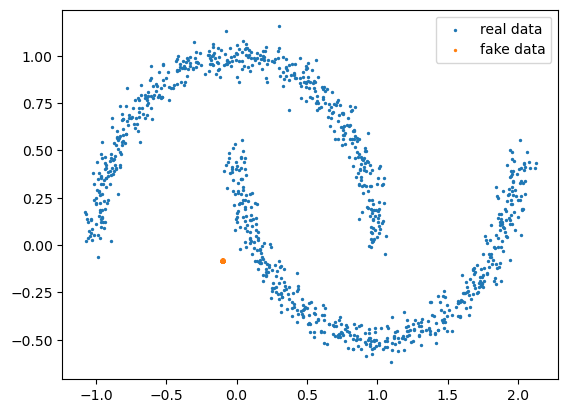

step 10000: discriminator: 1.348e+00, generator: 7.213e-01


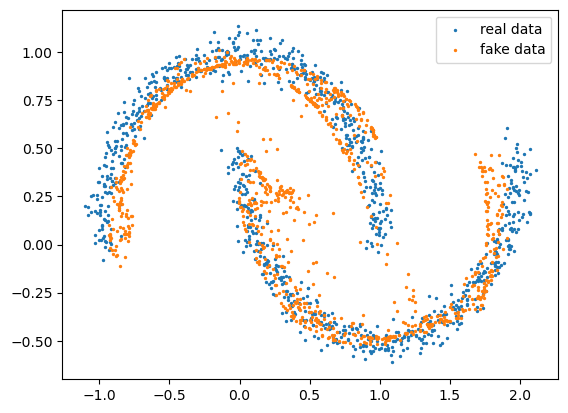

step 20000: discriminator: 1.384e+00, generator: 6.973e-01


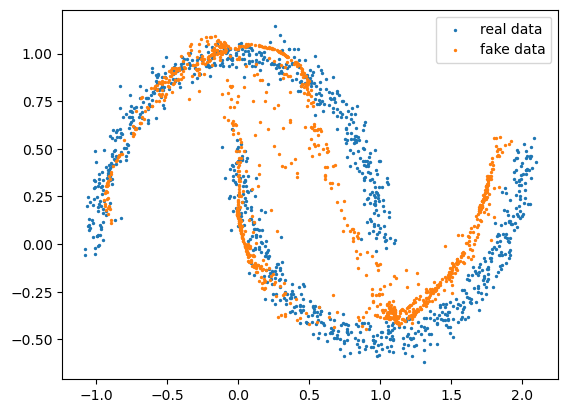

train_ratio 5, depth 5, width 100
step 0: discriminator: 1.372e+00, generator: 7.038e-01


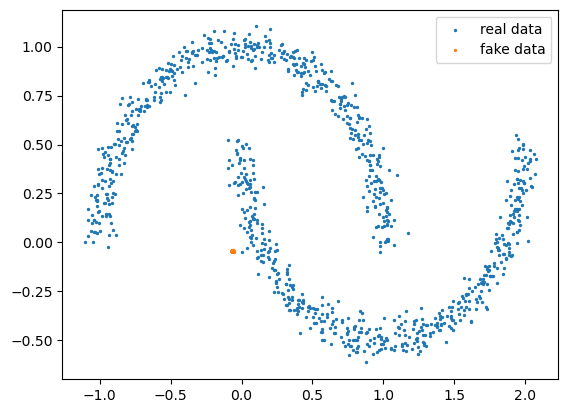

step 10000: discriminator: 1.319e+00, generator: 7.044e-01


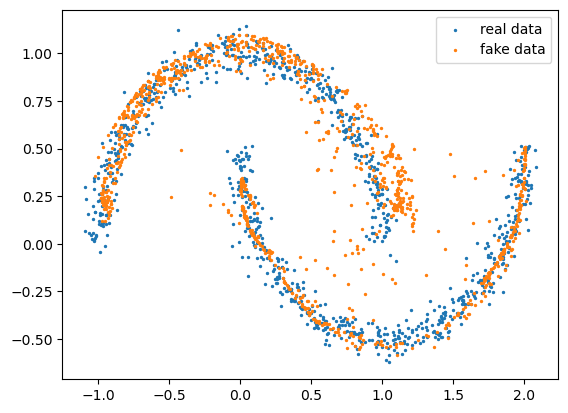

step 20000: discriminator: 1.386e+00, generator: 6.931e-01


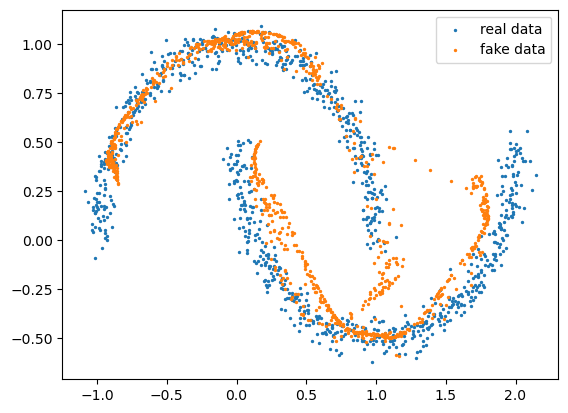

In [32]:
for train_ratio in [2,5]:
    for depth in [5]:
        for width in [50, 100]:
            print(f'train_ratio {train_ratio}, depth {depth}, width {width}')
            train(train_ratio, depth, width)

> We added hidden layers to the generator and discriminator and ran a pipeline to train multiple GANs with different values of the train_ratio, depth and width of the networks. Because of limited computational ressources we only test the scenario where the discriminator and the generator have the same depth and width.

> We mainly evaluate the models based on the visual results, as it might be tricky to interprete the generator and discrimnator losses. We train models with the following values of the hypeer-parameters of interest: 
  * train_ratio: [1, 2, 5]
  * Depth:: [2, 5, 10]
  * Width: [10, 30, 50, 70, 150]

> The first thing we can see is that having a **train_ratio** not too large is crucial, as when it is equal to 5 we clearly see the problem of vanishing gradient: the discrimnator is becoming too good too quickly and the generator is not able to update in a relevant way anymore. We find that the optimal value is around 1-2.

> As for the **depth** of the networks it appeears that the optimal value is around 5. For a value of 10 we observe a mode collapse. With too many parameters the model is overfitting. However increasing the depth of network was very beneficial for the learning as we can observe a huge improvement between our first  model without anay hidden layer and the one with 5 hidden layers. Therefore the depth parameter plays a very important role and it would be interesting to test a generator and a discriminator with different depth values.

> As for the depth parameter, the **width** of the nettworks also has an impact on learning. Too small and too big values lead to poor results and a value of 50 seems to be the best tradeoff to have a generator able to learn the target distribution correctly.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

----
### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

>Given that the expectation is linear, we can rewrite this expression as:
>
>$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(p_D) \right] - \mathbb{E}_{p_D}\left[ log(p_\theta) \right]$$ 
>
><br>
>
>Finnaly, $ \mathbb{E}_{p_D}\left[ log(p_D) \right] $ doesn't depend on $\theta$, so maximizing $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$ is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](./vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> The major problem is that the model may learn a wrong approximation of the true data distribution, and if the model overfits on this wrong approximation it will have extremely poor performance. <br>
> The model will also struggle to adapt to new distributions or different priors, and will likely have a more limited output diversity.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> $D_{KL}$ between two multivariate Gaussian distributions can be written as (From Eq. 3 of [\[On the Properties of Kullback-Leibler Divergence Between Multivariate Gaussian Distributions\]](https://arxiv.org/pdf/2102.05485.pdf)):
>
>$$D_{KL}(\mathcal{N}_1(\mu_1, \Sigma_1) \|\mathcal{N}_1(\mu_2, \Sigma_2)) = \frac{1}{2} \left[ \log\frac{|\Sigma_2|}{|\Sigma_1|} + \text{Tr}(\Sigma_2^{-1} \Sigma_1) + (\mu_2 - \mu_1)^T \Sigma_2^{-1} (\mu_2 - \mu_1) - n  \right]$$
>
>In our case we have:
>
>$$D_{KL}(q_\phi(z|x) \| p(z)) = \frac{1}{2} \left[ \log\frac{|I_d|}{|\text{Diag}(\sigma_\phi^2(x))|} + \text{Tr}(\text{Diag}(\sigma_\phi^2(x))) + \mu_\phi(x)^T \mu_\phi(x) - 1 \right]$$
>
> Given that:
> - $\text{Tr}(\text{Diag}(\sigma_\phi^2(x))) = \sum_{i=1}^{d} \sigma_{\phi_i}^2(x)$
> - $\mu_\phi(x)^T \mu_\phi(x) = \sum_{i=1}^{d} \mu_{\phi_i}^2(x)$
> - $|\text{Diag}(\sigma_\phi^2(x))| = \prod_{i=1}^{d} \sigma_{\phi_i}^2(x)$ 
>
> Finally:
>
>$$D_{KL}(q_\phi(z|x) \| p(z)) = \frac{1}{2} \sum_{i=1}^{d} \left[  \sigma_{\phi_i}^2(x) +  \mu_{\phi_i}^2(x) - \log \sigma_{\phi_i}^2(x) - 1 \right]$$
>
> With $d = Tr(I_d)$

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> Given that $$p_\theta(x | z) \sim \mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$$
>
>$p_\theta(x | z)$ can be written as:   $$  p_\theta(x | z) = \frac{1}{(2\pi)^{d/2}|Diag(\sigma^2_\theta(z))|^{1/2}} \exp \left(-\frac{1}{2} (x-\mu_\theta(z))^TDiag\left(\sigma^2_\theta(z)\right)^{-1}(x-\mu_\theta(z))\right)$$
<br>
> So, when applying the negative log we get : 
>$$ - \log p_\theta(x | z) = \frac{1}{2}  ( \log |Diag(\sigma^2_\theta(z))| + d \log (2 \pi)  + (x-\mu_\theta(z))^T Diag(\sigma^2_\theta(z))^{-1}(x-\mu_\theta(z)) ) $$



We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [9]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(2, LATENT_N)
        self.fc_logvar = nn.Linear(2, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)
        self.fc_logvar = nn.Linear(LATENT_N, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

In [82]:
device = torch.device("cpu") # Computation is faster on CPU when the model is simple
torch.set_default_device(device)

# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

def run_vae(encoder, decoder):

    optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
    optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

    for i in range(N_ITER):
        encoder.zero_grad()
        decoder.zero_grad()
        
        x = generate_batch(BATCHLEN).to(device)

        enc_mu, enc_logvar = encoder(x)
        #
        # COMPUTE THE KL PART OF THE LOSS HERE
        #

        loss_kl = 0.5 * torch.sum( torch.exp(enc_logvar) + enc_mu.pow(2) - enc_logvar - 1 )
        #
        # SAMPLE z FROM q(z|x) HERE
        #

        z = enc_mu + torch.exp(0.5 * enc_logvar) * torch.randn((BATCHLEN,LATENT_N))
        
        dec_mu, dec_logvar = decoder(z)
        #
        # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
        #
        
        loss_rec = 0.5 * torch.sum(dec_logvar + (x - dec_mu).pow(2) * torch.exp(-dec_logvar) + LATENT_N * np.log(2 * np.pi))
        
        if isinstance(encoder, Encoder):
            total_loss = loss_kl + loss_rec
        else:
            total_loss = 0.2 * loss_kl + 0.8 * loss_rec

        total_loss.backward()
        optim_enc.step()
        optim_dec.step()
        if i%5000 == 0:
            print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
            # plot the result
            real_batch = generate_batch(1024)
            
            rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()

            fake_batch = decoder.generate(1024).detach()
            
            plt.scatter(real_batch[:,0].cpu(), real_batch[:,1].cpu(), s=2.0, label='real data')
            plt.scatter(rec_batch[:,0].cpu(),  rec_batch[:,1].cpu(),  s=2.0, label='rec data')
            plt.scatter(fake_batch[:,0].cpu(), fake_batch[:,1].cpu(), s=2.0, label='fake data')
            plt.legend()
            plt.show()

step 0: KL: 4.408e+02, rec: 2.567e+03


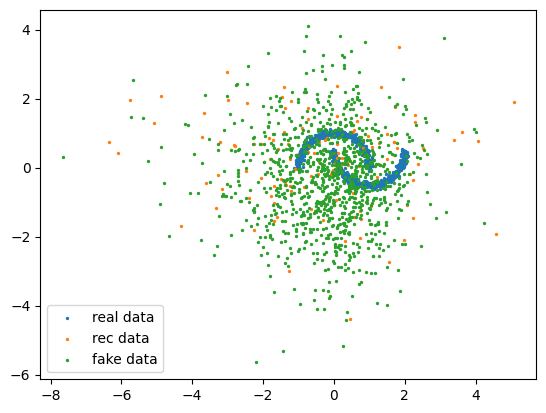

step 5000: KL: 5.915e+01, rec: 2.308e+03


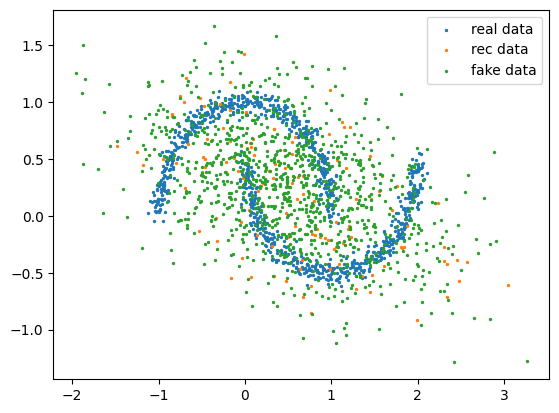

step 10000: KL: 6.340e+01, rec: 2.299e+03


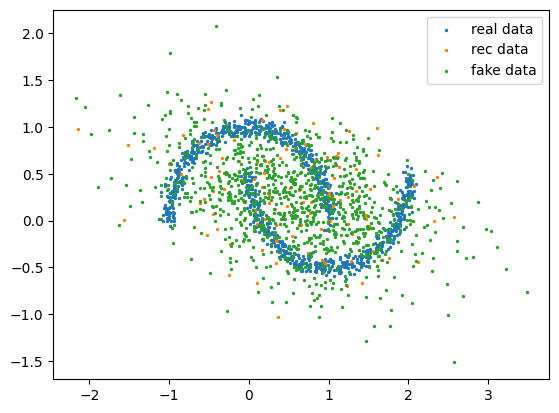

step 15000: KL: 6.412e+01, rec: 2.299e+03


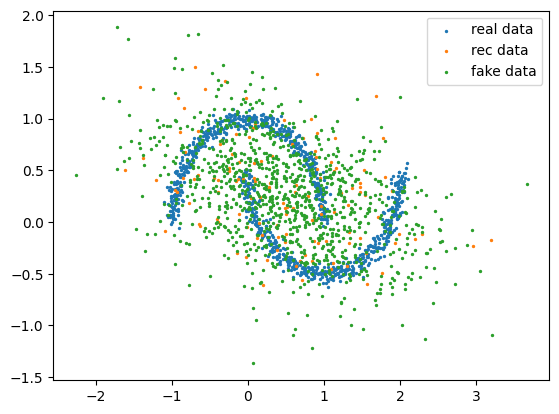

step 20000: KL: 6.501e+01, rec: 2.303e+03


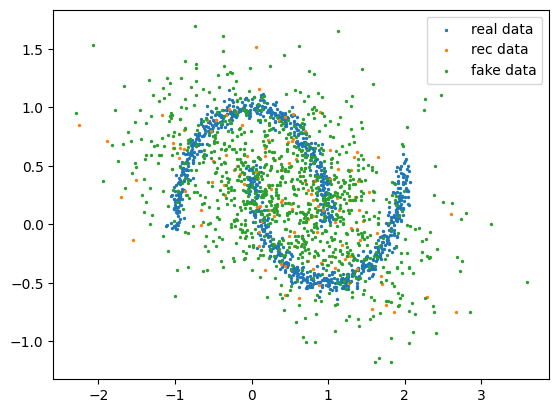

step 25000: KL: 6.601e+01, rec: 2.285e+03


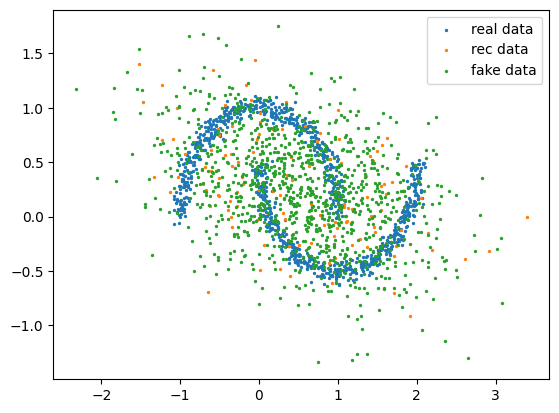

step 30000: KL: 6.406e+01, rec: 2.282e+03


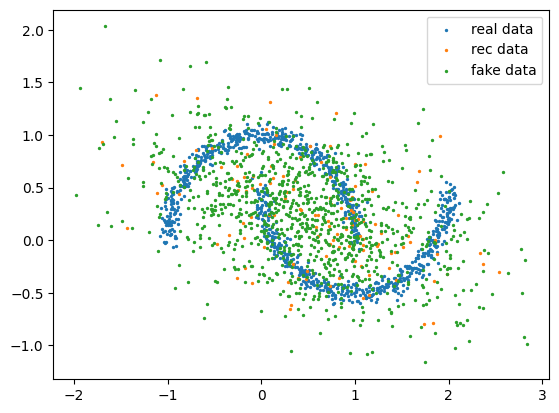

step 35000: KL: 6.244e+01, rec: 2.297e+03


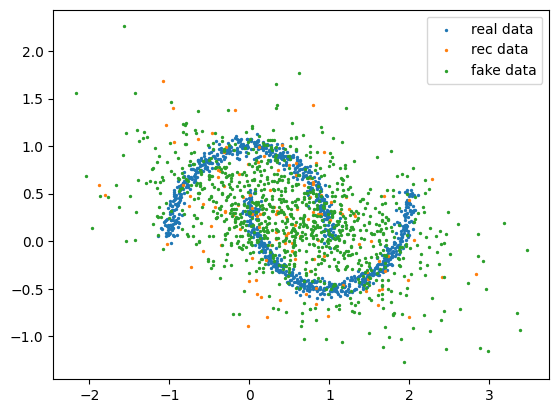

step 40000: KL: 6.377e+01, rec: 2.306e+03


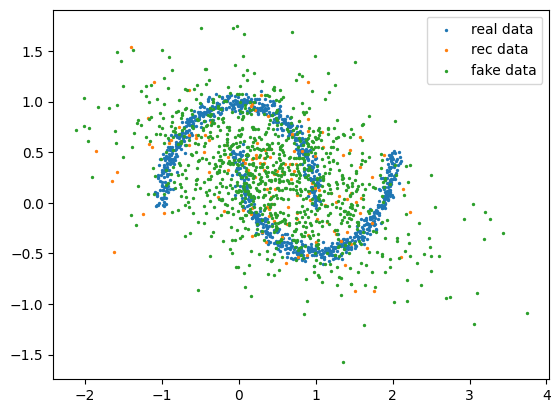

In [69]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

run_vae(encoder, decoder)

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

In [71]:
class DecoderFixedLogVar(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)
        self.fc_logvar = nn.Linear(LATENT_N, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, 1e-4)

step 0: KL: 4.491e+02, rec: 2.570e+03


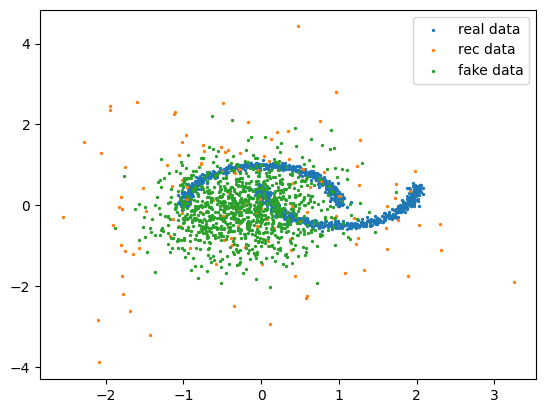

step 5000: KL: 6.327e+01, rec: 2.298e+03


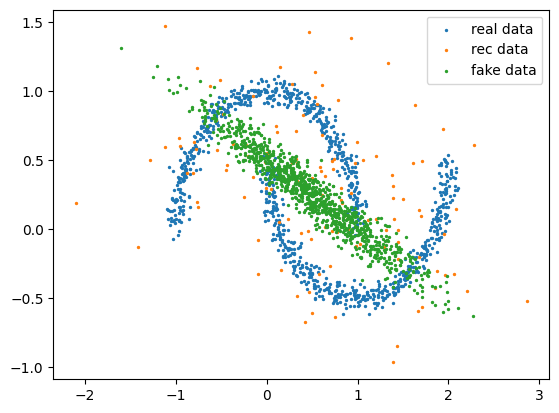

step 10000: KL: 6.677e+01, rec: 2.306e+03


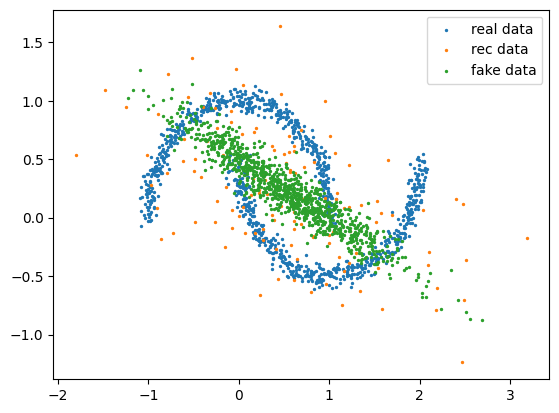

step 15000: KL: 6.514e+01, rec: 2.302e+03


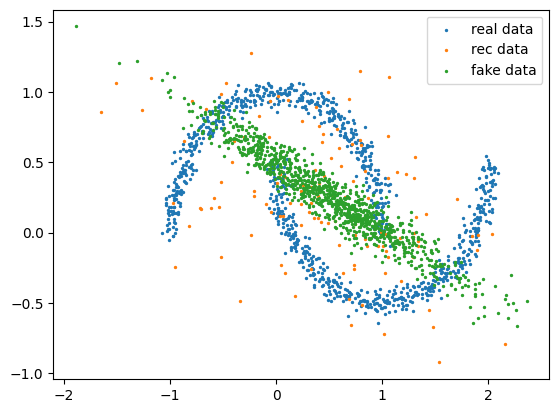

step 20000: KL: 6.412e+01, rec: 2.290e+03


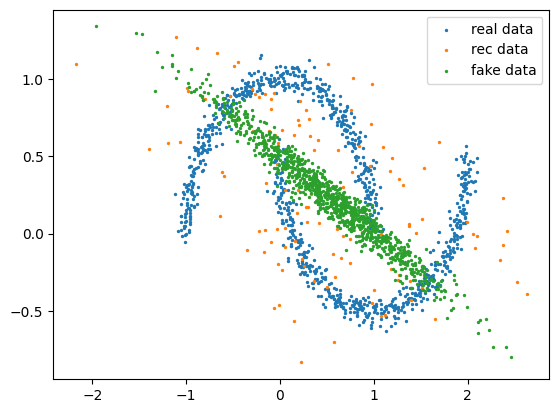

step 25000: KL: 6.530e+01, rec: 2.300e+03


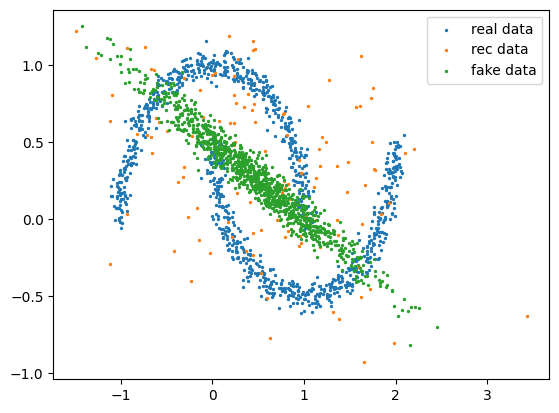

step 30000: KL: 6.312e+01, rec: 2.287e+03


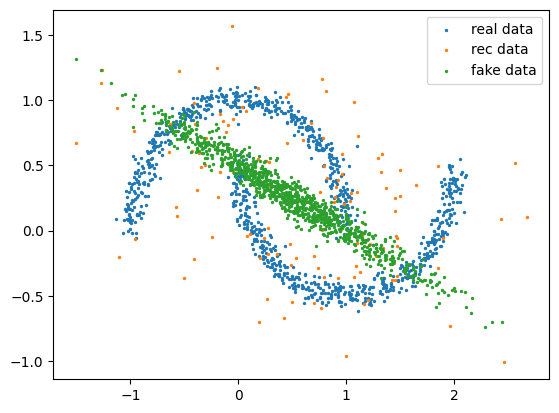

step 35000: KL: 6.288e+01, rec: 2.301e+03


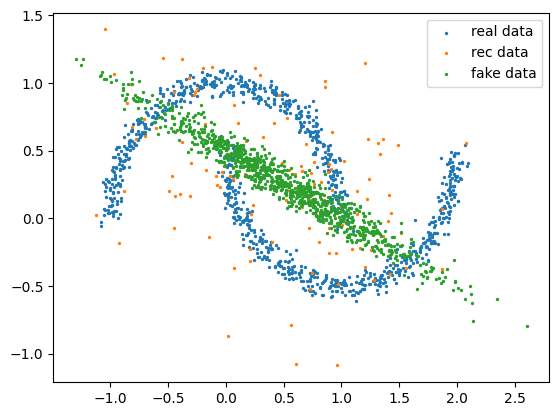

step 40000: KL: 6.393e+01, rec: 2.295e+03


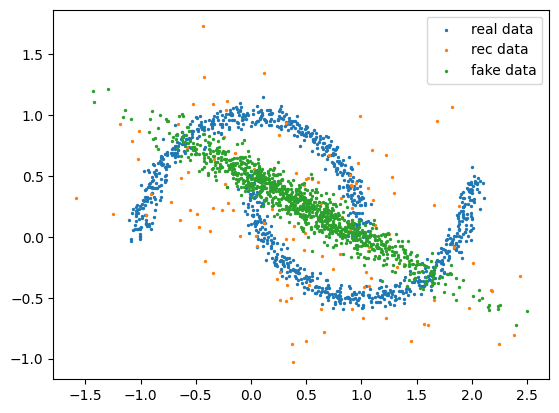

In [72]:
decoder = DecoderFixedLogVar()
encoder = Encoder()

run_vae(encoder, decoder)

> ***(The run_VAE function has been updated to generate the right recontructed data)*** <br><br>
> Given that the model doesn't have to learn the variance of the distribution, it can focus only on the mean, leading to much better results. <br>
> However, we can clearly see that due to the only presence of linear layers the model is not powerful enough to generate proper data.

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

> To address this question, we updated both the Encoder and Decoder classes by adding a MLP before the fully connected layers.<br>
> We experimented with an increasing amount of layers and increased size of the hidden layer. <br>
> We reached good results with 5 layers of 100 neurons at 30000 iterations. <br>
> Increasing the size of the model allowed it to achieve better results with a lower amount of iterations, but at the expense of an increased risk of overfitting. <br>
> 
> Now, about the influence of the encoder and decoder themselves. <br>
> The encoder defines the ability of the model to encode the data in the latent space, meaning that having a more capable encoder improves the capacity of the model to create a better low-dimensional representation of the data, which eventually leads to fewer errors during data reconstruction. When using a very small amount of hidden layers in the Encoder, the model is not able to create a latent space allowing for the generalization on the two arcs of the moon dataset<br><br>
> The decoder seems to have a lower impact on the generalization capacity of the model. Indeed, we managed to get good qualitative results with a smaller amount of layers (3). However, we did get better results by increasing the weight of the reconstruction loss on the total loss. 

In [73]:
def instanciate_mlp(hidden_layers, input_dim):
    
    layers = list()
    
    for hidden_size in hidden_layers:
        layers.append(nn.Linear(input_dim, hidden_size))
        layers.append(nn.ReLU())
        
        input_dim = hidden_size

    return nn.Sequential(*layers), input_dim

In [84]:
class EncoderMLP(nn.Module):
    def __init__(self, 
                 hidden_layers: list, 
                 input_dim=2, 
                 output_dim=LATENT_N):
        
        super().__init__()        

        mlp_layers, mpl_output_dim = instanciate_mlp(hidden_layers, input_dim)

        self.mlp       = mlp_layers
        self.fc_mu     = nn.Linear(mpl_output_dim, output_dim)
        self.fc_logvar = nn.Linear(mpl_output_dim, output_dim)

    def __call__(self, x):
        x = self.mlp(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    

class DecoderMLP(nn.Module):
    def __init__(self, 
                 hidden_layers: list, 
                 input_dim=LATENT_N, 
                 output_dim=2):
        
        super().__init__()

        mlp_layers, mpl_output_dim = instanciate_mlp(hidden_layers, input_dim)

        self.mlp       = mlp_layers
        self.fc_mu     = nn.Linear(mpl_output_dim, output_dim)
        self.fc_logvar = nn.Linear(mpl_output_dim, output_dim)

    def __call__(self, z):
        z = self.mlp(z)
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

step 0: KL: 3.401e+00, rec: 2.446e+03


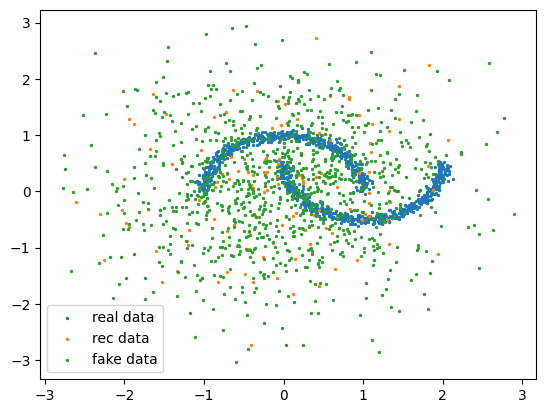

step 5000: KL: 6.834e+02, rec: 1.706e+03


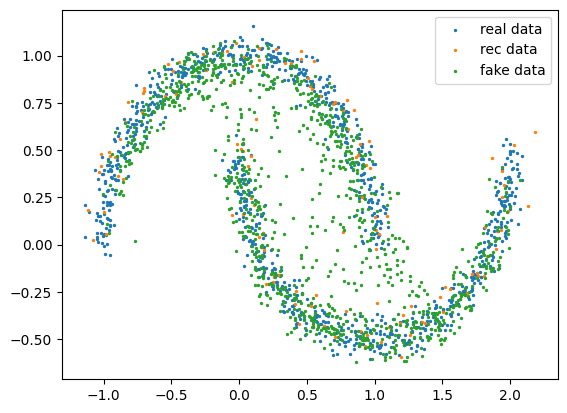

step 10000: KL: 7.599e+02, rec: 1.671e+03


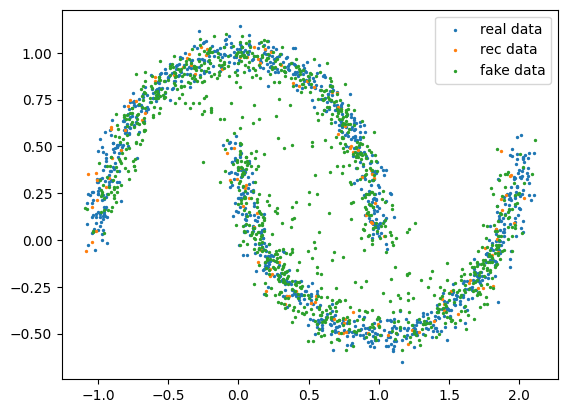

step 15000: KL: 8.432e+02, rec: 1.512e+03


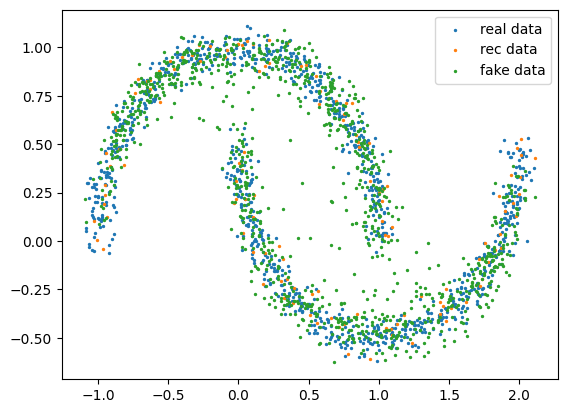

step 20000: KL: 8.985e+02, rec: 1.427e+03


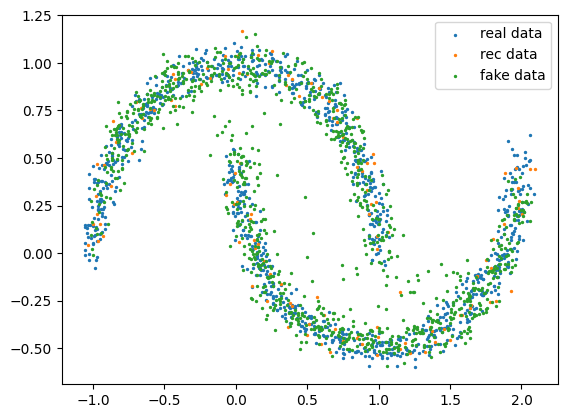

step 25000: KL: 9.108e+02, rec: 1.381e+03


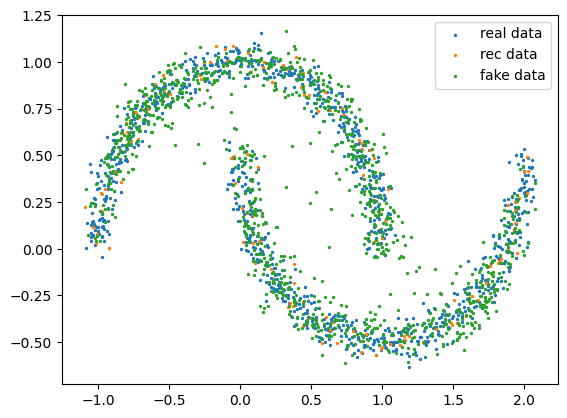

step 30000: KL: 9.379e+02, rec: 1.385e+03


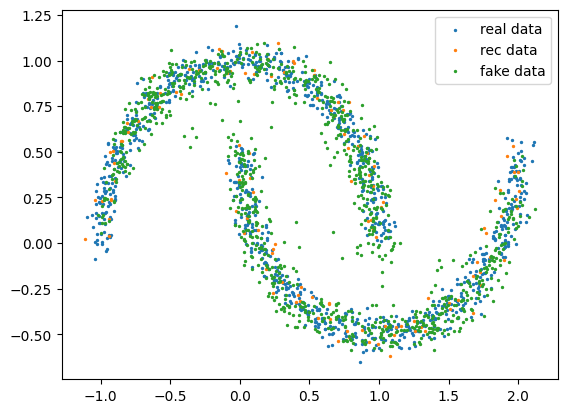

In [91]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

N_ITER = 30001

n_hidden  = 5
mlp_sizes = [100] * n_hidden


encoderMLP = EncoderMLP(mlp_sizes).to(device)
decoderMLP = DecoderMLP(mlp_sizes).to(device)

run_vae(encoderMLP, decoderMLP)

**Q.28: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs, Normalizing flows and Denoising Models ?**

> *In order to get more insight on the matter, we read the following paper, which influenced this conclusion ([Deep Generative Modelling: A Comparative Review of VAEs, GANs, Normalizing Flows, Energy-Based and Autoregressive Models](https://arxiv.org/pdf/2103.04922.pdf))* <br><br>
> GANs can generate high-quality and realistic samples but they have many drawbacks. One of the most notable is their tendency for training instability, which can result in mode collapse, when the generator fails to produce a diverse set of outputs. Furthermore, evaluating the quality of GAN-generated samples is very difficult, presenting significant hurdles for model comparison and progress assessment.
>
> VAEs, in contrast, excel in constructing a structured and meaningful latent space. This capability facilitates various manipulations, such as smooth interpolations between points in the latent space. They also have a very stable training behavior. However, VAEs tend to generate samples that, while structurally coherent, lack the sharpness and detail typically seen in GAN outputs. Finaly, it is difficult to approximate the posterior distribution in this family of models.
>
>
> The main advantage of Normalizing Flows is that they allow to compute exact log-likelihood, allowing for both direct optimization of the model and precise evaluation. Furthermore, given that these models are invertible, they are able to provide efficient and accurate density estimation. However, the requirement for invertible transformations complicates the model architecture, leading to increased computational demands, particularly for high-dimensional data. This complexity also limits their generation capabilities.
>
> Denoising Models offer robust feature learning capabilities by recovering clean data from corrupted inputs. This process not only improves the model's generalization over various tasks, including image restoration and error correction but also enhances its robustness against noise. However, the effectiveness of these models heavily relies on the underlying noise model, which may not always accurately represent real-world data corruption. Moreover, the iterative nature of generating data through denoising steps can result in much slower inference times compared to more direct generative approaches.